## Imports

In [2]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from collections import Counter
from wordcloud import WordCloud
from IPython.display import Image

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

In [3]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Clustering de documents de 1960 à 1969

In [4]:
data_path = "../data/txt/"
txt_path = "../data/txt"

In [5]:
#choisir une décénnie
DECADE = '1960'

# Charger tous les  fichiers de la décennie et en créer une liste de textes
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]
texts = [open(data_path + f).read() for f in files]

### Vectoriser les documents à l'aide de TF-IDF

In [6]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

# Instancier le modèle TF-IDF avec ses arguments
vectorizer1 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words = stopwords.words("french"),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
%time tfidf_vectors1 = vectorizer1.fit_transform(texts)

CPU times: user 3min 30s, sys: 0 ns, total: 3min 30s
Wall time: 3min 30s


### Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

In [7]:
# Définir un nombre de clusters
N_CLUSTERS = 3

# Instancier le modèle K-Means et ses arguments
km_model1 = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction `fit_predict`
clusters1 = km_model1.fit_predict(tfidf_vectors1)

clustering1 = collections.defaultdict(list)

for idx, label in enumerate(clusters1):
    clustering1[label].append(files[idx])

### Visualiser les clusters

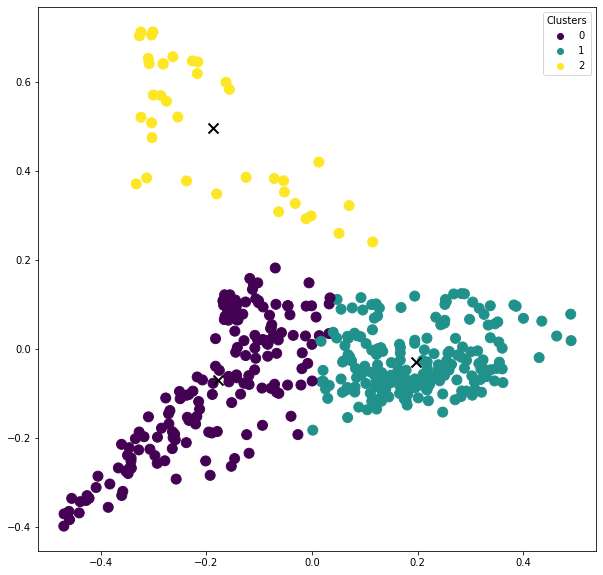

In [8]:
pca1 = PCA(n_components=2)
reduced_vectors1 = pca1.fit_transform(tfidf_vectors1.toarray())

# Générer le plot
x_axis1 = reduced_vectors1[:, 0]
y_axis1 = reduced_vectors1[:, 1]

plt.figure(figsize=(10,10))
scatter1 = plt.scatter(x_axis1, y_axis1, s=100, c=clusters1)

# Ajouter les centroïdes
centroids1 = pca1.transform(km_model1.cluster_centers_)
plt.scatter(centroids1[:, 0], centroids1[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter1.legend_elements()[0], labels=set(clusters1), title="Clusters")

# 2. Analyse du Term Frequency (TF)

### Sortir la liste des mots les plus fréquents au travers de tous les documents de la décénnie

In [9]:
# Stocker le contenu des fichiers de la décénnie dans une liste
content_list = []
for txt in files:
    with open(os.path.join(txt_path, txt), 'r') as f:
        content_list.append(f.read())

# Ecrire tout le contenu dans un fichier temporaire
temp_path = '../data/tmp'
if not os.path.exists(temp_path):
    os.mkdir(temp_path)
with open(os.path.join(temp_path, f'frequence.txt'), 'w') as f:
    f.write(' '.join(content_list))   
    
#Afficher les 100 termes les plus fréquents
with open(os.path.join(temp_path, f'frequence.txt'), 'r') as f:
    cluster_0 = f.read()
frequencies = Counter(cluster_0.split())
print(frequencies.most_common(300))



[('de', 503759), ('e', 436702), ('i', 261057), ('n', 255083), ('r', 241493), ('a', 234461), ('s', 221162), ('l', 198325), ('.', 192123), ('la', 180688), ('o', 169850), ('t', 169221), ('é', 159218), ('u', 158993), ('à', 151474), ('—', 149328), ('m', 144247), ('et', 141560), ('des', 125450), ('le', 124718), ('du', 105486), ('d', 100726), ('c', 100518), ('en', 100186), ('les', 92356), ('M', 90687), ('que', 83750), ('p', 81405), (',', 76268), ("'", 70469), ('van', 64515), ('pour', 59889), ('v', 51947), ('par', 49290), ('au', 48282), ('E', 46424), ('qui', 45629), ('est', 41523), ('g', 40502), ('dans', 38341), ('une', 37971), ('pas', 37720), ('un', 36906), ('ce', 34883), ('C', 34124), ('L', 33138), ('A', 32395), ('1', 32106), ('het', 31793), (';', 31506), (':', 31325), ('je', 31171), ('ne', 30650), ('b', 28865), ('I,', 28695), ('h', 27943), ('nous', 27906), ('q', 27817), ('-', 27491), ('sur', 26610), ('V', 25604), ('aux', 25019), ('y', 24712), ('è', 24501), ('vous', 22905), ('2', 22630), ('0

In [10]:
# Mettre les mots les plus fréquents dans une liste de Stopwords 
sw = stopwords.words("french")
sw += ["de", "e", "i", "n", "r", "a", "s", "l", ".", "la", "o", "t", "é", "u", "à", "—", "m", 
       "et", "des", "le", "du", "d", "c", "en", "les", "m", "que", "p", ",", "'", "van", "pour", 
       "v", "par", "au", "e", "qui", "est", "g", "dans", "une", "pas", "un", "ce", "c", "l", "a", "1", 
       "het", ";", ":", "je", "ne", "b", "i,", "h", "nous", "q", "-", "sur", "V", "aux", "y", "è", "vous", 
       "2", "0", "d", "de", "sont", "«", "ou", "cette", "il", "B", "N", "x", "f", "", "s", "il", "i", "plus", 
       "Je", "r", "été", "se", "»", "p", "t", "O", "in", "d'une", "francs", "een", "", "rue", "ê", "op", "voor",
       "te", "", "", "", "qu'il", "tout", "", "ces", "conseil", "faire", "mais", "fait", "d'un", "U", "ont", "ii,", "ii",
       "c'est", "9", "h", "avec", "ville", "être", "budget", "publique", "g", "le", "comme", "collège", "art.", "aan", 
       "monsieur", "l'article", "on", "commission", "8", "j", "sera", "dat", "k", "soit", "bien", "", "die", "si", 
       "travaux", "f", "me", "communal", "d'assistance", "10", "décembre", "van", "m.", "+", "dont", "n°", "considérant", 
       "cela", "deux", "Les", "compte", "son", "dépense", "l'echevin", "loi", "crois", "n'est", "bruxelles", "Service", 
       "».", "%", "cours", "membres", "door", "er", "messieurs,", "messieurs", "met", "même", "is", "fr.", "fr", "très", "notre", "dit", 
       "worden", "mars", "leur", "question", "tôt", "donc", "avons", "der", "peut", "of", "tous", "entre", "rapport", 
       "encore", "service", "mesdames", "où", "ses", "plan", "", "sans", "cet", "non", "?", "*", "sa", "demande", "francs.", 
       "Nous", "ainsi", "faut", "dire", "part", "december", "La", "bourgmestre.", "bourgmestre" , "cas", "En", "bourgmestre,", "zijn", "", 
       "concerne", "vue", "sous", "vu", "2", "intervention,", "intervention", "aussi", "date", "parce", "nomination,", "nomination", "l'on", "taxe", "doit", 
       "niet", "prix", "l'etat", "juin", "lieu", "serait", "z", "personnel", "moins", "déjà", "", "partie", "nombre", "délibération", 
       "»,", "dépenses", "", "point", "avait", "wordt", "heer", "francs,", "c'est", "par", "14", "1967", "Bruxelles,", 
       "»,", "dépenses", "", "professeur", "voudrais", "", "J", "avis", "communes", "proposition", "frais", "janvier", "budget", 
       "également", "", "octobre", "", "deze", "depuis", "novembre", "que,", "recettes", "", "services", "bij", "rue", "het", 
       "a", "", "projet", "nos", "", "toutes", "toute", "trois", "mais"]
sw = set(sw)


### Vectoriser les documents à l'aide de TF-IDF en faisant passer la liste de stopwords

/usr/local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['art'] not in stop_words.
  warnings.warn(


CPU times: user 3min 22s, sys: 37.7 ms, total: 3min 22s
Wall time: 3min 22s


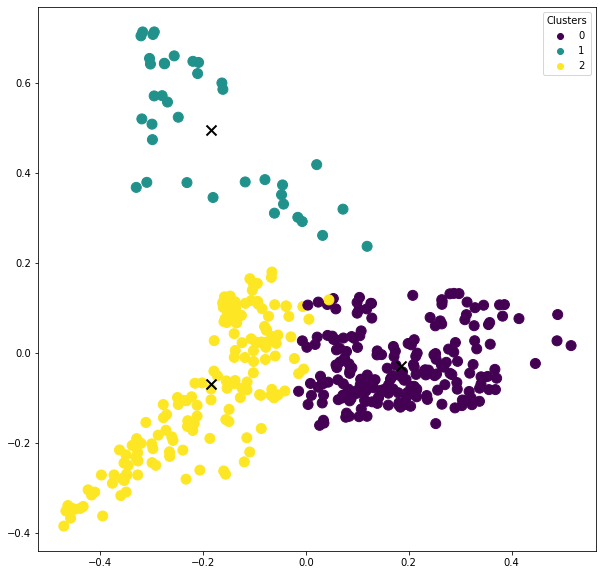

In [11]:
# Instancier le modèle TF-IDF avec ses arguments et on passe la liste de stop words
vectorizer2 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words = sw,
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
%time tfidf_vectors2 = vectorizer2.fit_transform(texts)

# Définir un nombre de clusters
N_CLUSTERS = 3

# Instancier le modèle K-Means et ses arguments
km_model2 = KMeans(n_clusters=N_CLUSTERS)

# Appliquer le clustering à l'aide de la fonction `fit_predict`
clusters2 = km_model2.fit_predict(tfidf_vectors2)

clustering2 = collections.defaultdict(list)

for idx, label in enumerate(clusters2):
    clustering2[label].append(files[idx])

pca2 = PCA(n_components=2)
reduced_vectors2 = pca2.fit_transform(tfidf_vectors2.toarray())

# Générer le plot
x_axis2 = reduced_vectors2[:, 0]
y_axis2 = reduced_vectors2[:, 1]

plt.figure(figsize=(10,10))
scatter2 = plt.scatter(x_axis2, y_axis2, s=100, c=clusters2)

# Ajouter les centroïdes
centroids2 = pca2.transform(km_model2.cluster_centers_)
plt.scatter(centroids2[:, 0], centroids2[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter2.legend_elements()[0], labels=set(clusters2), title="Clusters")    


# 3. Analyse du  term frequency-inverse document frequency (TD-IDF)

### Cluster 0

In [12]:
# Lister les fichiers du cluster 0 de notre première vectorisation

txts_0 = [f for f in clustering1[0] if os.path.isfile(os.path.join(txt_path, f))]
texts_0 = [open(data_path + f).read() for f in txts_0]

# Instancier le modèle TF-IDF avec ses arguments
vectorizer_0 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words = stopwords.words("french"),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors_0 = vectorizer_0.fit_transform(texts_0)

In [13]:
pd.Series(
    tfidf_vectors_0[0].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)

fer              0.251933
curage           0.225927
art              0.174050
dma              0.145997
considérant      0.145997
                   ...   
déplacements     0.000000
déplacement      0.000000
dépistage        0.000000
dépense++pour    0.000000
™                0.000000
Length: 5932, dtype: float64

In [14]:
pd.Series(
    tfidf_vectors_0[1].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)


considérant              0.323275
appareil                 0.270979
a+l'honneur              0.237367
ses+explications         0.200244
d'étude                  0.199659
                           ...   
désignation              0.000000
dérogation               0.000000
dépêche                  0.000000
députation+permanente    0.000000
™                        0.000000
Length: 5932, dtype: float64

In [15]:
pd.Series(
    tfidf_vectors_0[2].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)


max            0.467469
hauteur        0.339724
numéros        0.268038
gemeente       0.244674
locale         0.205652
                 ...   
engagements    0.000000
10.000         0.000000
enfant         0.000000
enduits        0.000000
™              0.000000
Length: 5932, dtype: float64

In [16]:
pd.Series(
    tfidf_vectors_0[3].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)

un+avis         0.197924
favorable.++    0.182543
.++il           0.178367
imputée         0.131512
ik              0.126435
                  ...   
dépassé         0.000000
dépasser        0.000000
dépassent       0.000000
dépassements    0.000000
™               0.000000
Length: 5932, dtype: float64

In [17]:
pd.Series(
    tfidf_vectors_0[4].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)

additionnels     0.280922
carburant        0.255685
d'huile          0.178087
distributeurs    0.164761
centimes         0.158916
                   ...   
figurer          0.000000
figurent         0.000000
figure           0.000000
figurait         0.000000
#                0.000000
Length: 5932, dtype: float64

In [18]:
pd.Series(
    tfidf_vectors_0[5].toarray()[0],
    index=vectorizer_0.get_feature_names_out()
    ).sort_values(ascending=False)

moteur      0.172731
expirant    0.156060
objets      0.153918
138         0.151202
§           0.147026
              ...   
délivrer    0.000000
délicate    0.000000
délicat     0.000000
dégâts      0.000000
™           0.000000
Length: 5932, dtype: float64

### Cluster 1

In [19]:
# Lister les fichiers du cluster 1 de notre première vectorisation

txts_1 = [f for f in clustering1[1] if os.path.isfile(os.path.join(txt_path, f))]
texts_1 = [open(data_path + f).read() for f in txts_1]

# Instancier le modèle TF-IDF avec ses arguments
vectorizer_1 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words = stopwords.words("french"),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors_1 = vectorizer_1.fit_transform(texts_1)


In [20]:
pd.Series(
    tfidf_vectors_1[0].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)

l'éclairage    0.220534
miljoen        0.175427
artères        0.166168
éclairage      0.156661
jeux           0.150108
                 ...   
ernstige       0.000000
erkende        0.000000
erediensten    0.000000
eraan          0.000000
j'entends      0.000000
Length: 7378, dtype: float64

In [21]:
pd.Series(
    tfidf_vectors_1[1].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)


belasting      0.487940
spectacles     0.158239
§              0.153740
moteur         0.140979
pratiques      0.113174
                 ...   
entraîne       0.000000
entièrement    0.000000
entier         0.000000
entente        0.000000
™              0.000000
Length: 7378, dtype: float64

In [22]:
pd.Series(
    tfidf_vectors_1[2].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)


prêts           0.519300
belasting       0.248591
+considérant    0.159084
prêt            0.148637
meter           0.126850
                  ...   
engage          0.000000
enerzijds       0.000000
ene             0.000000
endroit         0.000000
j'entends       0.000000
Length: 7378, dtype: float64

In [23]:
pd.Series(
    tfidf_vectors_1[3].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)

vervolg      0.420899
stijging     0.259563
parents      0.164759
garderies    0.160979
revenus      0.153180
               ...   
effectifs    0.000000
effectif     0.000000
eerst        0.000000
eens         0.000000
™            0.000000
Length: 7378, dtype: float64

In [24]:
pd.Series(
    tfidf_vectors_1[4].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)

belasting            0.356977
aandelen             0.168480
opcentiemen          0.160165
evolutie             0.137039
gemeentebelasting    0.133924
                       ...   
ecoutez              0.000000
ecoles               0.000000
ecole                0.000000
echevins+et          0.000000
™                    0.000000
Length: 7378, dtype: float64

In [25]:
pd.Series(
    tfidf_vectors_1[5].toarray()[0],
    index=vectorizer_1.get_feature_names_out()
    ).sort_values(ascending=False)

miljoen                               0.471310
vermindering                          0.228873
steden                                0.195601
weddeschalen                          0.168708
binnenlandse                          0.146122
                                        ...   
e+des                                 0.000000
e+d                                   0.000000
e+bruxelles++gemeenteblad+bulletin    0.000000
e+a                                   0.000000
™                                     0.000000
Length: 7378, dtype: float64

### Cluster 2

In [26]:
# Lister les fichiers du cluster 2 de notre première vectorisation

txts_2 = [f for f in clustering1[2] if os.path.isfile(os.path.join(txt_path, f))]
texts_2 = [open(data_path + f).read() for f in txts_2]

# Instancier le modèle TF-IDF avec ses arguments
vectorizer_2 = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words = stopwords.words("french"),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

# Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`
tfidf_vectors_2 = vectorizer_2.fit_transform(texts_2)


In [27]:
pd.Series(
    tfidf_vectors_2[0].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)

communes    0.224932
mots        0.213496
19          0.187089
valeur      0.181326
alinéa      0.175200
              ...   
de+f        0.000000
de+deux     0.000000
de+de       0.000000
de+d        0.000000
•—          0.000000
Length: 5671, dtype: float64

In [28]:
pd.Series(
    tfidf_vectors_2[1].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)


hôpitaux       0.363963
intérimaire    0.318242
assistant      0.297479
part-time      0.229261
1960           0.181361
                 ...   
demie          0.000000
demi           0.000000
demanet        0.000000
demandé        0.000000
•—             0.000000
Length: 5671, dtype: float64

In [29]:
pd.Series(
    tfidf_vectors_2[2].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)


intérimaire    0.446106
hôpitaux       0.364426
assistant      0.249488
part-time      0.222490
1961.          0.190086
                 ...   
de++           0.000000
davantage      0.000000
dat            0.000000
danse          0.000000
•—             0.000000
Length: 5671, dtype: float64

In [30]:
pd.Series(
    tfidf_vectors_2[3].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)

c'est                 0.286932
cela                  0.242789
tout                  0.205970
appartements          0.200656
monsieur              0.165538
                        ...   
achats                0.000000
accueillis            0.000000
accoucheuse           0.000000
iii                   0.000000
geyt.+intervention    0.000000
Length: 5671, dtype: float64

In [31]:
pd.Series(
    tfidf_vectors_2[4].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)

hôpitaux          0.241306
m++i              0.229815
intérimaire       0.182861
full-time         0.154728
assistant         0.146094
                    ...   
de+c              0.000000
de+bruxelles      0.000000
de+bourgmestre    0.000000
de+belgique       0.000000
•—                0.000000
Length: 5671, dtype: float64

In [32]:
pd.Series(
    tfidf_vectors_2[5].toarray()[0],
    index=vectorizer_2.get_feature_names_out()
    ).sort_values(ascending=False)

intérimaire    0.249893
1961           0.224331
1961.          0.203927
1962           0.176674
1960           0.176674
                 ...   
de+tion        0.000000
de+stad        0.000000
de+s           0.000000
de+r           0.000000
•—             0.000000
Length: 5671, dtype: float64

# 4.Word Embeddings : le modèle Word2Vec

## Chargement et traitement des phrases du corpus

In [3]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [5]:
#en raison d'un processeur trop peu puissant, j'ai du limiter mon corpus à 1.500.000 lignes 
infile = f"../data/sents-1000000.txt"
sentences = MySentences(infile)

### Détection des bigrams

In [6]:
bigram_phrases = Phrases(sentences)

In [7]:
%time bigram_phrases[sentences]

CPU times: user 0 ns, sys: 3.82 ms, total: 3.82 ms
Wall time: 8.1 ms


In [8]:
bigram_phraser = Phraser(phrases_model=bigram_phrases)

In [9]:
%time bigram_phraser[sentences]

CPU times: user 5.51 ms, sys: 79 µs, total: 5.59 ms
Wall time: 11.6 ms


### Extraction des trigrams

In [10]:
trigram_phrases = Phrases(bigram_phraser[sentences])

In [11]:
trigram_phraser = Phraser(phrases_model=trigram_phrases)

### Création d'un corpus d'unigrams, bigrams, trigrams

In [12]:
corpus = list(trigram_phraser[bigram_phraser[sentences]])

## Entrainement d'un modèle Word2Vec sur ce corpus

In [14]:
# window de 10 et minimum count de 3
model_10 = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=10, # La taille du "contexte", ici 10 mots avant et après le mot observé
    min_count=3, # On ignore les mots qui n'apparaissent pas au moins 3 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

In [15]:
# window de 5 et minimum count de 3
model_5 = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=5, # La taille du "contexte", ici 5 mots avant et après le mot observé
    min_count=3, # On ignore les mots qui n'apparaissent pas au moins 3 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

In [17]:
# window de 5 et minimum count de 3
model_3 = Word2Vec(
    corpus, # On passe le corpus de ngrams que nous venons de créer
    vector_size=32, # Le nombre de dimensions dans lesquelles le contexte des mots devra être réduit, aka. vector_size
    window=3, # La taille du "contexte", ici 3 mots avant et après le mot observé
    min_count=3, # On ignore les mots qui n'apparaissent pas au moins 3 fois dans le corpus
    workers=4, # Permet de paralléliser l'entraînement du modèle en 4 threads
    epochs=5 # Nombre d'itérations du réseau de neurones sur le jeu de données pour ajuster les paramètres avec la descende de gradient, aka. epochs.
)

In [19]:
outfile_10 = f"../data/bulletins_10.model"
model_10.save(outfile_10)
outfile_5 = f"../data/bulletins_5.model"
model_5.save(outfile_5)
outfile_3 = f"../data/bulletins_3.model"
model_3.save(outfile_3)

In [20]:
# Charger les modèles en mémoire
model_10 = Word2Vec.load("../data/bulletins_10.model")
model_5 = Word2Vec.load("../data/bulletins_5.model")
model_3 = Word2Vec.load("../data/bulletins_3.model")

#### Calculer la similarité entre deux termes

In [29]:
# modèle avec une fenêtre de 10
model_10.wv.similarity("pyck", "boulangerie")

0.2587824

In [30]:
# modèle avec une fenêtre de 5
model_5.wv.similarity("pyck", "boulangerie")

0.099157035

In [31]:
# modèle avec une fenêtre de 3
model_3.wv.similarity("pyck", "boulangerie")

0.11328696

In [32]:
# modèle avec une fenêtre de 10
model_10.wv.similarity("hospices", "secours")

0.59421873

In [33]:
# modèle avec une fenêtre de 5
model_5.wv.similarity("hospices", "secours")

0.71156883

In [34]:
# modèle avec une fenêtre de 3
model_3.wv.similarity("hospices", "secours")

0.64987683

In [41]:
# modèle avec une fenêtre de 10
model_10.wv.similarity("senne", "eau")

0.31226623

In [42]:
# modèle avec une fenêtre de 5
model_5.wv.similarity("senne", "eau")

0.1945188

In [43]:
# modèle avec une fenêtre de 3
model_3.wv.similarity("senne", "eau")

0.11307154

#### Chercher les mots les plus proches d'un terme donné

In [48]:
# Pyck avec le modèle 10
model_10.wv.most_similar("pyck", topn=10)

[('chez_:_pyck', 0.8902500867843628),
 ('poul', 0.8863022923469543),
 ('philippc', 0.884736955165863),
 ('francken', 0.8786367177963257),
 ('vanlinthout', 0.878516435623169),
 ('lauwers', 0.8745033740997314),
 ('vandoren', 0.8740551471710205),
 ('vantilborg', 0.8732500672340393),
 ('goossens', 0.8724875450134277),
 ('vanheyde', 0.8701719641685486)]

In [49]:
# Pyck avec le modèle 5
model_5.wv.most_similar("pyck", topn=10)

[('remparl', 0.9255620837211609),
 ('vandoren', 0.9176997542381287),
 ('goossens', 0.9022705554962158),
 ('philip_.-', 0.8958896398544312),
 ('casteels', 0.8924674987792969),
 ('bellis', 0.8906906843185425),
 ('ruerempart', 0.8872766494750977),
 ('dandois', 0.8844153881072998),
 ('hermosa', 0.8843221068382263),
 ('vantilborg', 0.8838886618614197)]

In [50]:
# Pyck avec le modèle 3
model_3.wv.most_similar("pyck", topn=10)

[('bonnewyns', 0.9179213047027588),
 ('casteels', 0.9062473773956299),
 ('gits', 0.8948764801025391),
 ('stoven', 0.894692063331604),
 ('vanhauwermeiren', 0.8915500044822693),
 ('plas', 0.8907470107078552),
 ('goossens', 0.8888978958129883),
 ('devos', 0.88877934217453),
 ('gauthier', 0.8840600252151489),
 ('hofman', 0.8834925889968872)]

In [51]:
# hospices avec le modèle 10
model_10.wv.most_similar("hospices", topn=10)

[('hospiees', 0.7343834042549133),
 ('biens', 0.70567786693573),
 ('accepter', 0.6829085946083069),
 ('pauvres', 0.6793174147605896),
 ('interets_echus', 0.6705607771873474),
 ('pensions', 0.6676180958747864),
 ('hospices_sollicite', 0.6672908067703247),
 ('heritiers', 0.66596919298172),
 ('communes_domiciles', 0.6578744649887085),
 ('hospices_soumet', 0.6559008955955505)]

In [52]:
# hospices avec le modèle 5
model_5.wv.most_similar("hospices", topn=10)

[('secours', 0.7115689516067505),
 ('pensions', 0.7073390483856201),
 ('pauvres', 0.6972392201423645),
 ('biens', 0.6722543835639954),
 ('hopitaux', 0.67146897315979),
 ('hospiees', 0.6714039444923401),
 ('indigents', 0.666096568107605),
 ('avances_faites', 0.6427794694900513),
 ('legs_faits', 0.6372552514076233),
 ('heritiers', 0.6331526637077332)]

In [53]:
# hospices avec le modèle 3
model_3.wv.most_similar("hospices", topn=10)

[('pauvres', 0.7269168496131897),
 ('pensions', 0.7229649424552917),
 ('indigents', 0.7169917225837708),
 ('communes', 0.6884328722953796),
 ('subsides', 0.6872151494026184),
 ('concessionnaires', 0.6784259080886841),
 ('voyageurs_indigents', 0.6551738977432251),
 ('fabriques', 0.6542097330093384),
 ('secours', 0.6498767733573914),
 ('familles', 0.6431863307952881)]

In [54]:
# Senne avec le modèle 10
model_10.wv.most_similar("senne", topn=10)

[('vallee', 0.852684497833252),
 ('riviere', 0.8288551568984985),
 ('derivation', 0.823672890663147),
 ('petite_senne', 0.7955650687217712),
 ('canalisation', 0.775702953338623),
 ('rive_gauche', 0.7696417570114136),
 ('communication_directe', 0.7568836808204651),
 ('transformation', 0.7521178722381592),
 ('aval', 0.7493820190429688),
 ('pavage', 0.749167263507843)]

In [55]:
# Senne avec le modèle 5
model_5.wv.most_similar("senne", topn=10)

[('riviere', 0.8417099714279175),
 ('vallee', 0.8090066909790039),
 ('bourse', 0.79034423828125),
 ('voirie', 0.7788036465644836),
 ('voie_publique', 0.77467280626297),
 ('petite_senne', 0.774482786655426),
 ('facade_principale', 0.7682957649230957),
 ('rue_royale', 0.7651747465133667),
 ('derivation', 0.756596028804779),
 ('drainage', 0.754658579826355)]

In [56]:
# Senne avec le modèle 3
model_3.wv.most_similar("senne", topn=10)

[('riviere', 0.8753912448883057),
 ('voirie', 0.8306054472923279),
 ('jonction', 0.8149849772453308),
 ('bourse', 0.797382652759552),
 ('voie_publique', 0.7895113825798035),
 ('vallee', 0.788027286529541),
 ('porte_louise', 0.7820837497711182),
 ('rive_gauche', 0.7797362804412842),
 ('digue', 0.7755283713340759),
 ('rue_royale', 0.7740044593811035)]